In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import sys

# ajouter le chemin racine pour importer src/
ROOT = Path("..").resolve()
sys.path.append(str(ROOT))

from src.data_preprocessing import load_raw_data, basic_cleaning
from src.features import add_derived_features, split_train_val_test
from src.config import DATA_PROCESSED_DIR, THRESHOLD_HIGH_DELAY

pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

In [2]:
df_raw = load_raw_data()
print("Shape brut :", df_raw.shape)

df_clean = basic_cleaning(df_raw)
print("Shape après cleaning :", df_clean.shape)

df_clean.head()

Shape brut : (171666, 21)
Shape après cleaning : (171426, 21)


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,3.16,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,0.57,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,1.80,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,4.47,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,2.96,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [3]:
df_feat = add_derived_features(df_clean)

df_feat[[
    "year", "month", "carrier", "airport",
    "arr_flights", "arr_del15", "arr_delay",
    "delay_rate", "avg_delay_per_flight",
    "cancel_rate", "divert_rate",
    "carrier_delay_per_flight",
    "weather_delay_per_flight",
    "nas_delay_per_flight",
    "security_delay_per_flight",
    "late_aircraft_delay_per_flight",
    "high_delay_risk"
]].head()

,year,month,carrier,airport,arr_flights,arr_del15,arr_delay,delay_rate,avg_delay_per_flight,cancel_rate,divert_rate,carrier_delay_per_flight,weather_delay_per_flight,nas_delay_per_flight,security_delay_per_flight,late_aircraft_delay_per_flight,high_delay_risk
0,2023,8,9E,ABE,89.0,13.0,1375.0,0.146067,15.449438,0.022472,0.011236,0.797753,8.550562,1.325843,0.0,4.775281,0
1,2023,8,9E,ABY,62.0,10.0,799.0,0.161290,12.887097,0.000000,0.016129,3.516129,0.016129,1.000000,0.0,8.354839,0
2,2023,8,9E,AEX,62.0,10.0,766.0,0.161290,12.354839,0.016129,0.000000,0.903226,3.032258,1.258065,0.0,7.161290,0
3,2023,8,9E,AGS,66.0,12.0,1397.0,0.181818,21.166667,0.015152,0.015152,7.136364,4.848485,5.878788,0.0,3.303030,0
4,2023,8,9E,ALB,92.0,22.0,1530.0,0.239130,16.630435,0.021739,0.000000,6.826087,0.000000,1.456522,0.0,8.347826,1


In [4]:
df_feat["high_delay_risk"].value_counts(normalize=True)

high_delay_risk
0    0.620577
1    0.379423
Name: proportion, dtype: float64

Counts :
 high_delay_risk
0    106383
1     65043
Name: count, dtype: int64

Ratios :
 high_delay_risk
0    0.620577
1    0.379423
Name: count, dtype: float64


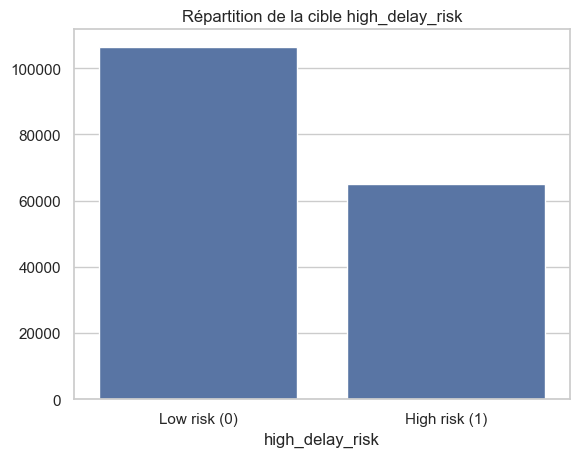

In [5]:
target_counts = df_feat["high_delay_risk"].value_counts()
target_ratio = target_counts / len(df_feat)

print("Counts :\n", target_counts)
print("\nRatios :\n", target_ratio)

sns.barplot(x=target_counts.index, y=target_counts.values)
plt.xticks([0,1], ["Low risk (0)", "High risk (1)"])
plt.title("Répartition de la cible high_delay_risk")
plt.show()

In [6]:
train, val, test = split_train_val_test(df_feat)

print("Train :", train.shape)
print("Val   :", val.shape)
print("Test  :", test.shape)

Train : (119998, 31)
Val   : (25714, 31)
Test  : (25714, 31)


In [7]:
DATA_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

train.to_csv(DATA_PROCESSED_DIR / "train.csv", index=False)
val.to_csv(DATA_PROCESSED_DIR / "val.csv", index=False)
test.to_csv(DATA_PROCESSED_DIR / "test.csv", index=False)

DATA_PROCESSED_DIR, list(DATA_PROCESSED_DIR.glob("*.csv"))

(WindowsPath('C:/Users/Balerion/Desktop/us-flights-delay/data/processed'),
 [WindowsPath('C:/Users/Balerion/Desktop/us-flights-delay/data/processed/test.csv'),
  WindowsPath('C:/Users/Balerion/Desktop/us-flights-delay/data/processed/test_weather.csv'),
  WindowsPath('C:/Users/Balerion/Desktop/us-flights-delay/data/processed/train.csv'),
  WindowsPath('C:/Users/Balerion/Desktop/us-flights-delay/data/processed/train_weather.csv'),
  WindowsPath('C:/Users/Balerion/Desktop/us-flights-delay/data/processed/val.csv'),
  WindowsPath('C:/Users/Balerion/Desktop/us-flights-delay/data/processed/val_weather.csv')])

## Résumé Feature Engineering

- Nettoyage :
  - Lignes avec `arr_flights <= 0` supprimées.
  - Lignes sans `year`, `month`, `carrier`, `airport` supprimées.

- Features dérivées :
  - `delay_rate = arr_del15 / arr_flights`
  - `avg_delay_per_flight = arr_delay / arr_flights`
  - `cancel_rate`, `divert_rate`
  - `*_delay_per_flight` pour chaque cause (carrier, weather, nas, security, late_aircraft)

- Cible classification :
  - `high_delay_risk = 1{delay_rate > THRESHOLD_HIGH_DELAY}`
  - Seuil utilisé : `THRESHOLD_HIGH_DELAY = {{THRESHOLD_HIGH_DELAY}}`

- Split :
  - Train / Val / Test avec stratification sur `high_delay_risk`.